# 2. Beta–Binomial Classifier

This notebook demonstrates how to use the Beta–Binomial model to classify mastery levels from grouped count data (attempts and successes). We'll learn how to:

- Compute posterior distributions for each group
- Calculate credible intervals to quantify uncertainty
- Assign mastery labels using threshold-based classification
- Understand why we use the lower bound of the credible interval

## 2.1 Overview: From Data to Classification

The Beta–Binomial classifier takes **grouped binary outcomes** (like "5 attempts, 3 successes") and assigns mastery labels:
- **Attempted**: Still learning, not yet familiar
- **Familiar**: Comfortable with the material
- **Proficient**: Mastered the concept

**Key Insight**: Instead of using just the posterior mean, we use the **lower bound of the credible interval** to make conservative classifications that account for uncertainty.


## 2.3 Import Libraries and Set Up Parameters

Let's start by importing the necessary libraries and defining our classification parameters:


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import beta

print("Libraries imported successfully!")


Libraries imported successfully!


### Set Up Classification Parameters

We need to define:
1. **Prior parameters**: Our belief before seeing data (same as Notebook 1)
2. **Classification thresholds**: When to assign each label
3. **Confidence level**: For computing credible intervals


In [16]:
# Prior parameters (same as in Notebook 1)
alpha_prior = 2.0
beta_prior = 2.0

# Classification thresholds
familiar_threshold = 0.3      # Lower bound must be ≥ 0.3 for "Familiar"
proficient_threshold = 0.5    # Lower bound must be ≥ 0.5 for "Proficient"

# Confidence level for credible intervals
confidence = 0.8  # 80% credible interval

print("Classification Parameters:")
print(f"  Prior: Beta(α={alpha_prior}, β={beta_prior})")
print(f"  Familiar threshold: {familiar_threshold:.0%} (lower bound ≥ {familiar_threshold:.0%})")
print(f"  Proficient threshold: {proficient_threshold:.0%} (lower bound ≥ {proficient_threshold:.0%})")
print(f"  Confidence level: {confidence:.0%}")
print("\nClassification Rules:")
print(f"  - Proficient: Lower bound ≥ {proficient_threshold:.0%}")
print(f"  - Familiar: Lower bound ≥ {familiar_threshold:.0%} but < {proficient_threshold:.0%}")
print(f"  - Attempted: Lower bound < {familiar_threshold:.0%}")


Classification Parameters:
  Prior: Beta(α=2.0, β=2.0)
  Familiar threshold: 30% (lower bound ≥ 30%)
  Proficient threshold: 50% (lower bound ≥ 50%)
  Confidence level: 80%

Classification Rules:
  - Proficient: Lower bound ≥ 50%
  - Familiar: Lower bound ≥ 30% but < 50%
  - Attempted: Lower bound < 30%


## 2.4 Load and Explore the Data

Let's load our example dataset and see what we're working with:


In [17]:
# Load the data
data_path = Path('../data/beta_binomial_examples.csv')
examples = pd.read_csv(data_path)

print("Dataset Overview:")
print("=" * 60)
print(f"Number of groups: {len(examples)}")
print(f"\nColumns: {list(examples.columns)}")
print(f"\nFirst few rows:")
print(examples.head(10))

print(f"\n\nData Statistics:")
print("=" * 60)
print(f"Attempts: min={examples['attempts'].min()}, max={examples['attempts'].max()}, mean={examples['attempts'].mean():.1f}")
print(f"Successes: min={examples['successes'].min()}, max={examples['successes'].max()}, mean={examples['successes'].mean():.1f}")
print(f"Success rate (raw): min={(examples['successes']/examples['attempts']).min():.1%}, "
      f"max={(examples['successes']/examples['attempts']).max():.1%}, "
      f"mean={(examples['successes']/examples['attempts']).mean():.1%}")


Dataset Overview:
Number of groups: 10

Columns: ['group_id', 'attempts', 'successes']

First few rows:
  group_id  attempts  successes
0        A         2          1
1        A         5          3
2        B         1          0
3        B         7          6
4        C        10          4
5        D         3          3
6        E         8          2
7        F        12          9
8        G         4          1
9        H         6          5


Data Statistics:
Attempts: min=1, max=12, mean=5.8
Successes: min=0, max=9, mean=3.4
Success rate (raw): min=0.0%, max=100.0%, mean=54.4%


## 2.5 Classification Function: Step-by-Step

Let's build the classification process step by step. For each group, we need to:

1. **Compute posterior parameters** (α_post, β_post)
2. **Calculate posterior mean** (best point estimate)
3. **Calculate credible interval** (uncertainty range)
4. **Extract lower bound** (conservative estimate)
5. **Assign label** based on lower bound thresholds


In [18]:
# Example: Classify a single group step-by-step
# Let's use the first row as an example
example_row = examples.iloc[0]
group_id = example_row['group_id']
attempts = int(example_row['attempts'])
successes = int(example_row['successes'])
failures = attempts - successes

print(f"Example: Group {group_id}")
print("=" * 60)
print(f"Observed data: {successes} successes out of {attempts} attempts ({successes/attempts:.1%})")
print(f"\nStep 1: Compute posterior parameters")
print(f"  α_post = α_prior + successes = {alpha_prior} + {successes} = {alpha_prior + successes}")
print(f"  β_post = β_prior + failures = {beta_prior} + {failures} = {beta_prior + failures}")

alpha_post = alpha_prior + successes
beta_post = beta_prior + failures

print(f"\nStep 2: Calculate posterior mean")
post_mean = alpha_post / (alpha_post + beta_post)
print(f"  post_mean = α_post / (α_post + β_post)")
print(f"  post_mean = {alpha_post} / ({alpha_post} + {beta_post}) = {post_mean:.4f} ({post_mean:.1%})")

print(f"\nStep 3: Calculate credible interval")
lower_percentile = (1 - confidence) / 2
upper_percentile = 1 - lower_percentile
ci_low = beta.ppf(lower_percentile, alpha_post, beta_post)
ci_high = beta.ppf(upper_percentile, alpha_post, beta_post)
print(f"  Lower percentile: {lower_percentile:.1%}")
print(f"  Upper percentile: {upper_percentile:.1%}")
print(f"  80% Credible Interval: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"                      : [{ci_low:.1%}, {ci_high:.1%}]")

print(f"\nStep 4: Extract lower bound for classification")
print(f"  Lower bound (ci_low): {ci_low:.4f} ({ci_low:.1%})")

print(f"\nStep 5: Assign label based on thresholds")
print(f"  Check: Is {ci_low:.1%} ≥ {proficient_threshold:.0%}? {ci_low >= proficient_threshold}")
if ci_low >= proficient_threshold:
    label = 'Proficient'
elif ci_low >= familiar_threshold:
    label = 'Familiar'
else:
    label = 'Attempted'

print(f"  Result: {label}")
print(f"\nInterpretation:")
print(f"  - Even though the mean is {post_mean:.1%}, we're only {confidence:.0%} confident")
print(f"    the true ability is at least {ci_low:.1%}")
print(f"  - Since {ci_low:.1%} {'≥' if ci_low >= proficient_threshold else '<'} {proficient_threshold:.0%}, "
      f"the label is '{label}'")


Example: Group A
Observed data: 1 successes out of 2 attempts (50.0%)

Step 1: Compute posterior parameters
  α_post = α_prior + successes = 2.0 + 1 = 3.0
  β_post = β_prior + failures = 2.0 + 1 = 3.0

Step 2: Calculate posterior mean
  post_mean = α_post / (α_post + β_post)
  post_mean = 3.0 / (3.0 + 3.0) = 0.5000 (50.0%)

Step 3: Calculate credible interval
  Lower percentile: 10.0%
  Upper percentile: 90.0%
  80% Credible Interval: [0.2466, 0.7534]
                      : [24.7%, 75.3%]

Step 4: Extract lower bound for classification
  Lower bound (ci_low): 0.2466 (24.7%)

Step 5: Assign label based on thresholds
  Check: Is 24.7% ≥ 50%? False
  Result: Attempted

Interpretation:
  - Even though the mean is 50.0%, we're only 80% confident
    the true ability is at least 24.7%
  - Since 24.7% < 50%, the label is 'Attempted'


## 2.6 Classify All Groups

Now let's apply this process to all groups in our dataset:


In [19]:
# Classify all groups
results = []

for _, row in examples.iterrows():
    # Extract data
    attempts = int(row['attempts'])
    successes = int(row['successes'])
    failures = attempts - successes
    
    # Step 1: Compute posterior
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + failures
    
    # Step 2: Calculate posterior mean
    post_mean = alpha_post / (alpha_post + beta_post)
    
    # Step 3: Calculate credible interval
    lower_percentile = (1 - confidence) / 2
    ci_low = beta.ppf(lower_percentile, alpha_post, beta_post)
    ci_high = beta.ppf(1 - lower_percentile, alpha_post, beta_post)
    
    # Step 4: Classify based on lower bound
    if ci_low >= proficient_threshold:
        label = 'Proficient'
    elif ci_low >= familiar_threshold:
        label = 'Familiar'
    else:
        label = 'Attempted'
    
    # Store results
    results.append({
        'group_id': row['group_id'],
        'attempts': attempts,
        'successes': successes,
        'post_alpha': alpha_post,
        'post_beta': beta_post,
        'post_mean': post_mean,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'label': label
    })

# Create results DataFrame
classified_df = pd.DataFrame(results)
classified_df


,group_id,attempts,successes,post_alpha,post_beta,post_mean,ci_low,ci_high,label
0,A,2,1,3.0,3.0,0.500000,0.246636,0.753364,Attempted
1,A,5,3,5.0,4.0,0.555556,0.344623,0.760338,Familiar
2,B,1,0,2.0,3.0,0.400000,0.142559,0.679539,Attempted
3,B,7,6,8.0,3.0,0.727273,0.550396,0.884175,Proficient
4,C,10,4,6.0,8.0,0.428571,0.263730,0.598239,Attempted
5,D,3,3,5.0,2.0,0.714286,0.489684,0.907405,Familiar
6,E,8,2,4.0,8.0,0.333333,0.169233,0.510761,Attempted
7,F,12,9,11.0,5.0,0.687500,0.536029,0.828032,Proficient
8,G,4,1,3.0,5.0,0.375000,0.169638,0.596180,Attempted
9,H,6,5,7.0,3.0,0.700000,0.509919,0.870503,Proficient


## 2.7 Understanding the Classifications

Let's analyze the results and understand why each group received its label:


In [20]:
# Display detailed comparison
print("Detailed Classification Analysis")
print("=" * 80)

for _, row in classified_df.iterrows():
    observed_rate = row['successes'] / row['attempts']
    print(f"\nGroup {row['group_id']}: {row['successes']}/{row['attempts']} = {observed_rate:.1%} (observed)")
    print(f"  Posterior mean: {row['post_mean']:.1%}")
    print(f"  80% CI: [{row['ci_low']:.1%}, {row['ci_high']:.1%}]")
    print(f"  Classification: {row['label']} (because lower bound {row['ci_low']:.1%} "
          f"{'≥' if row['ci_low'] >= proficient_threshold else ('≥' if row['ci_low'] >= familiar_threshold else '<')} "
          f"{proficient_threshold:.0%} threshold)" if row['label'] == 'Proficient' else 
          f"{'≥' if row['ci_low'] >= familiar_threshold else '<'} {familiar_threshold:.0%} threshold)")

# Summary statistics
print("\n" + "=" * 80)
print("Summary Statistics:")
print("=" * 80)
print(f"\nLabel Distribution:")
label_counts = classified_df['label'].value_counts()
for label, count in label_counts.items():
    pct = count / len(classified_df) * 100
    print(f"  {label}: {count} groups ({pct:.1f}%)")

print(f"\nMean vs Lower Bound Comparison:")
print(f"  Mean average: {classified_df['post_mean'].mean():.1%}")
print(f"  Lower bound average: {classified_df['ci_low'].mean():.1%}")
print(f"  Difference: The lower bound is {(classified_df['post_mean'].mean() - classified_df['ci_low'].mean()):.1%} lower")
print(f"    (This shows our conservative approach)")


Detailed Classification Analysis

Group A: 1/2 = 50.0% (observed)
  Posterior mean: 50.0%
  80% CI: [24.7%, 75.3%]
< 30% threshold)

Group A: 3/5 = 60.0% (observed)
  Posterior mean: 55.6%
  80% CI: [34.5%, 76.0%]
≥ 30% threshold)

Group B: 0/1 = 0.0% (observed)
  Posterior mean: 40.0%
  80% CI: [14.3%, 68.0%]
< 30% threshold)

Group B: 6/7 = 85.7% (observed)
  Posterior mean: 72.7%
  80% CI: [55.0%, 88.4%]
  Classification: Proficient (because lower bound 55.0% ≥ 50% threshold)

Group C: 4/10 = 40.0% (observed)
  Posterior mean: 42.9%
  80% CI: [26.4%, 59.8%]
< 30% threshold)

Group D: 3/3 = 100.0% (observed)
  Posterior mean: 71.4%
  80% CI: [49.0%, 90.7%]
≥ 30% threshold)

Group E: 2/8 = 25.0% (observed)
  Posterior mean: 33.3%
  80% CI: [16.9%, 51.1%]
< 30% threshold)

Group F: 9/12 = 75.0% (observed)
  Posterior mean: 68.8%
  80% CI: [53.6%, 82.8%]
  Classification: Proficient (because lower bound 53.6% ≥ 50% threshold)

Group G: 1/4 = 25.0% (observed)
  Posterior mean: 37.5%
  80

## 2.8 Visualizing the Classification Logic

Let's create a visualization to understand how the classification works:


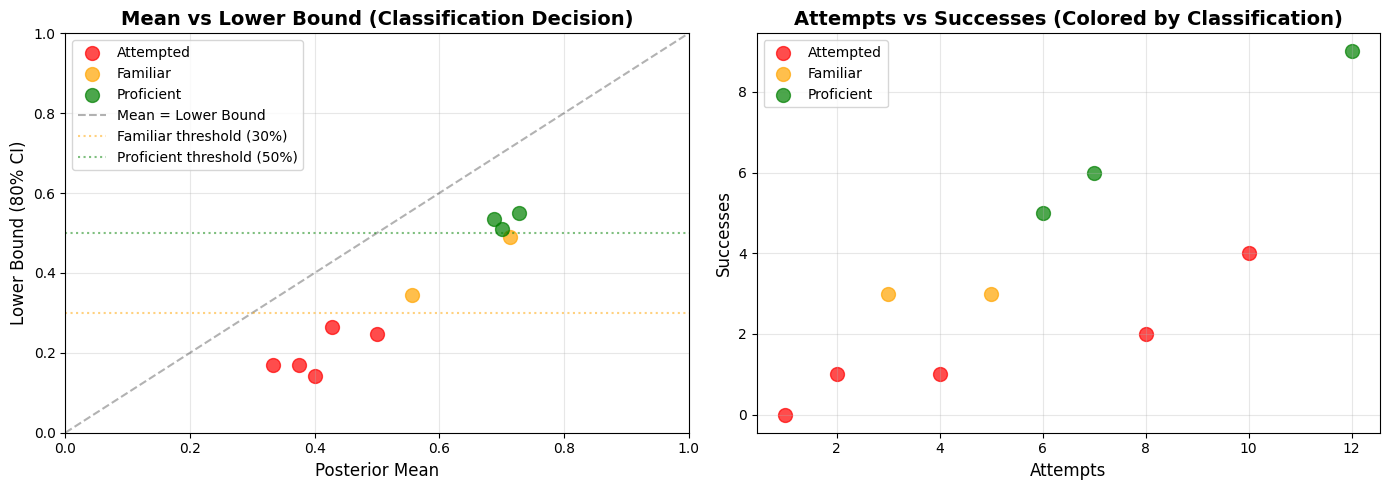


Key Insights:
1. Left plot: Points below the diagonal show groups where uncertainty is significant
2. Right plot: Shows that classifications depend on BOTH attempts and successes
3. Groups with the same success rate can have different labels based on sample size


In [21]:
# Create a scatter plot showing mean vs lower bound
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Mean vs Lower Bound
ax1 = axes[0]
colors = {'Attempted': 'red', 'Familiar': 'orange', 'Proficient': 'green'}
for label in ['Attempted', 'Familiar', 'Proficient']:
    mask = classified_df['label'] == label
    ax1.scatter(classified_df.loc[mask, 'post_mean'], 
                classified_df.loc[mask, 'ci_low'],
                label=label, alpha=0.7, s=100, c=colors[label])

# Add diagonal line (where mean = lower bound)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Mean = Lower Bound')
# Add threshold lines
ax1.axhline(familiar_threshold, color='orange', linestyle=':', alpha=0.5, label=f'Familiar threshold ({familiar_threshold:.0%})')
ax1.axhline(proficient_threshold, color='green', linestyle=':', alpha=0.5, label=f'Proficient threshold ({proficient_threshold:.0%})')

ax1.set_xlabel('Posterior Mean', fontsize=12)
ax1.set_ylabel('Lower Bound (80% CI)', fontsize=12)
ax1.set_title('Mean vs Lower Bound (Classification Decision)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Right plot: Attempts vs Successes with color coding
ax2 = axes[1]
for label in ['Attempted', 'Familiar', 'Proficient']:
    mask = classified_df['label'] == label
    ax2.scatter(classified_df.loc[mask, 'attempts'], 
                classified_df.loc[mask, 'successes'],
                label=label, alpha=0.7, s=100, c=colors[label])

ax2.set_xlabel('Attempts', fontsize=12)
ax2.set_ylabel('Successes', fontsize=12)
ax2.set_title('Attempts vs Successes (Colored by Classification)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("1. Left plot: Points below the diagonal show groups where uncertainty is significant")
print("2. Right plot: Shows that classifications depend on BOTH attempts and successes")
print("3. Groups with the same success rate can have different labels based on sample size")


## 2.9 Example: Why Lower Bound Matters

Let's see why using the lower bound instead of the mean makes a difference:


In [22]:
# Compare mean-based vs lower-bound-based classification
comparison = classified_df.copy()

# Classification based on mean
comparison['label_by_mean'] = comparison['post_mean'].apply(
    lambda x: 'Proficient' if x >= proficient_threshold 
              else ('Familiar' if x >= familiar_threshold else 'Attempted')
)

# Show differences
print("Comparison: Mean-based vs Lower-bound-based Classification")
print("=" * 80)

differences = comparison[comparison['label'] != comparison['label_by_mean']]
if len(differences) > 0:
    print(f"\nGroups with different classifications ({len(differences)} groups):")
    for _, row in differences.iterrows():
        print(f"\n  Group {row['group_id']}: {row['successes']}/{row['attempts']} = {row['successes']/row['attempts']:.1%}")
        print(f"    Mean: {row['post_mean']:.1%} → Label by mean: {row['label_by_mean']}")
        print(f"    Lower bound: {row['ci_low']:.1%} → Label by lower bound: {row['label']}")
        print(f"    Reason: Uncertainty makes us more conservative")
else:
    print("\nAll classifications agree (mean and lower bound lead to same labels)")

print(f"\nSummary:")
print(f"  Mean-based Proficient: {(comparison['label_by_mean'] == 'Proficient').sum()} groups")
print(f"  Lower-bound-based Proficient: {(comparison['label'] == 'Proficient').sum()} groups")
print(f"  Difference: Using lower bound is more conservative (fewer 'Proficient' labels)")


Comparison: Mean-based vs Lower-bound-based Classification

Groups with different classifications (7 groups):

  Group A: 1/2 = 50.0%
    Mean: 50.0% → Label by mean: Proficient
    Lower bound: 24.7% → Label by lower bound: Attempted
    Reason: Uncertainty makes us more conservative

  Group A: 3/5 = 60.0%
    Mean: 55.6% → Label by mean: Proficient
    Lower bound: 34.5% → Label by lower bound: Familiar
    Reason: Uncertainty makes us more conservative

  Group B: 0/1 = 0.0%
    Mean: 40.0% → Label by mean: Familiar
    Lower bound: 14.3% → Label by lower bound: Attempted
    Reason: Uncertainty makes us more conservative

  Group C: 4/10 = 40.0%
    Mean: 42.9% → Label by mean: Familiar
    Lower bound: 26.4% → Label by lower bound: Attempted
    Reason: Uncertainty makes us more conservative

  Group D: 3/3 = 100.0%
    Mean: 71.4% → Label by mean: Proficient
    Lower bound: 49.0% → Label by lower bound: Familiar
    Reason: Uncertainty makes us more conservative

  Group E: 2/8

## 2.10 Effect of Sample Size

Let's examine how sample size affects classifications:


In [23]:
# Find groups with similar success rates but different classifications
comparison = classified_df.copy()
comparison['success_rate'] = comparison['successes'] / comparison['attempts']

print("Effect of Sample Size on Classification")
print("=" * 80)
print("\nGroups with similar success rates but different classifications:")
print("\nGroup | Attempts | Successes | Rate | Mean | Lower Bound | Label")
print("-" * 80)

for _, row in comparison.iterrows():
    rate_str = f"{row['successes']}/{row['attempts']}"
    print(f"{row['group_id']:5s} | {row['attempts']:8d} | {row['successes']:9d} | "
          f"{row['success_rate']:4.1%} | {row['post_mean']:4.1%} | {row['ci_low']:11.1%} | {row['label']}")

print("\n" + "=" * 80)
print("Key Observation:")
print("  - Groups with same success rate can have different labels")
print("  - More attempts → narrower credible interval → higher lower bound")
print("  - This is why we need to consider uncertainty, not just the observed rate!")


Effect of Sample Size on Classification

Groups with similar success rates but different classifications:

Group | Attempts | Successes | Rate | Mean | Lower Bound | Label
--------------------------------------------------------------------------------
A     |        2 |         1 | 50.0% | 50.0% |       24.7% | Attempted
A     |        5 |         3 | 60.0% | 55.6% |       34.5% | Familiar
B     |        1 |         0 | 0.0% | 40.0% |       14.3% | Attempted
B     |        7 |         6 | 85.7% | 72.7% |       55.0% | Proficient
C     |       10 |         4 | 40.0% | 42.9% |       26.4% | Attempted
D     |        3 |         3 | 100.0% | 71.4% |       49.0% | Familiar
E     |        8 |         2 | 25.0% | 33.3% |       16.9% | Attempted
F     |       12 |         9 | 75.0% | 68.8% |       53.6% | Proficient
G     |        4 |         1 | 25.0% | 37.5% |       17.0% | Attempted
H     |        6 |         5 | 83.3% | 70.0% |       51.0% | Proficient

Key Observation:
  - Groups with sa

## 2.11 Summary: Key Concepts

Let's summarize what we've learned:

### Classification Process

1. **For each group:**
   - Compute posterior: Beta(α_prior + successes, β_prior + failures)
   - Calculate mean: α_post / (α_post + β_post)
   - Calculate credible interval: [ci_low, ci_high]

2. **Classification rule:**
   - Use the **lower bound** (ci_low) for conservative classification
   - Proficient: ci_low ≥ proficient_threshold
   - Familiar: ci_low ≥ familiar_threshold but < proficient_threshold
   - Attempted: ci_low < familiar_threshold

### Why This Approach Works

- **Accounts for uncertainty**: Small sample sizes have wider intervals
- **Conservative**: Prevents overconfidence with limited data
- **Bayesian**: Incorporates prior knowledge smoothly
- **Interpretable**: Each parameter has clear meaning

### When to Adjust Parameters

- **Prior (α, β)**: Adjust if you have domain knowledge about typical performance
- **Thresholds**: Adjust based on your definition of mastery
- **Confidence level**: Higher confidence → wider intervals → more conservative classifications


## 2.12 Next Steps

This classifier forms the foundation for adaptive learning systems. In the next notebook, we'll visualize the classification boundaries across all possible (attempts, successes) combinations to create a **mastery map**.

**Key Takeaways:**
- ✅ Beta–Binomial provides probabilistic classifications
- ✅ Using lower bound makes classifications conservative and reliable
- ✅ Sample size matters: more data → more confidence → better classifications
- ✅ Thresholds can be tuned based on your educational goals
